In [1]:
from __future__ import print_function

In [3]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.cross_validation import cross_val_score
from sklearn import feature_selection as f_select
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

/Users/younghojung/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
pos = 'QB'
df = pd.read_csv(pos+'_adj2.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head(5)

,pos,year,week,player,team,Fantasy Points,Fantasy Points_prev,Pass Attempts_prev,Pass Completions_prev,Passing Yards_prev,...,Sacks_prev_1yr_team,Interceptions_prev_1yr_team,Safeties_prev_1yr_team,Fumble Recoveries_prev_1yr_team,Blocked Kicks_prev_1yr_team,Touchdowns_prev_1yr_team,Points Against_prev_1yr_team,Passing Yards Allowed_prev_1yr_team,Rushing Yards Allowed_prev_1yr_team,Total Yards Allowed_prev_1yr_team
0,QB,2011,4,Aaron Rodgers,GB,53.0,27.0,38.0,28.0,297.0,...,47.0,24.0,0.0,8.0,0.0,4.0,240.0,194.2,114.9,309.1
1,QB,2011,4,Michael Vick,PHI,33.0,8.0,23.0,16.0,176.0,...,39.0,23.0,0.0,11.0,0.0,3.0,377.0,216.8,110.4,327.2
2,QB,2011,4,Tarvaris Jackson,SEA,27.0,12.0,31.0,18.0,171.0,...,37.0,12.0,1.0,10.0,3.0,6.0,407.0,249.6,118.9,368.6
3,QB,2011,4,Tony Romo,DAL,25.0,8.0,36.0,22.0,255.0,...,35.0,20.0,0.0,10.0,1.0,7.0,436.0,243.4,108.4,351.8
4,QB,2011,4,Josh Freeman,TB,25.0,12.0,32.0,22.0,180.0,...,26.0,19.0,0.0,9.0,0.0,4.0,318.0,201.0,131.7,332.7


In [54]:
df = df.sort_values(['year', 'week'])
y = df['Fantasy Points'].reset_index(drop=True)
X = df.drop(['Fantasy Points', 'pos', 'year', 'week', 'team', 'player'], axis=1).reset_index(drop=True)

In [59]:
## Here, I will select features based on the statistical significance
features = dict()
## store Mean Squared Errors for lasso and ridge regularization
lasso = dict()
ridge = dict()

for pos in ['K', 'QB', 'WR', 'RB', 'TE']:
    df = pd.read_csv(pos+'_adj2.csv')
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df = df.sort_values(['year', 'week'])
    y = df['Fantasy Points'].reset_index(drop=True)
    X = df.drop(['Fantasy Points', 'pos', 'year', 'week', 'team', 'player'], axis=1).reset_index(drop=True)

    df_train = df[df['year'] <= 2015]
    df_test = df[df['year'] > 2015]
    
    # feature selection
    est = LinearRegression()

    kf = KFold(n=len(X), n_folds=5, shuffle=True)
    all_scores = []

    # Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
    # us to 'manipulate' our training set, 

    # get indices of corresponding train & test
    for train,test in kf:
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        pvals=[]
        sig_cols=[]

        for feature in x_train.columns:
            pval=f_select.f_regression(x_train[[feature]],y_train)
            if pval[1][0]<.02: 
                sig_cols.append(feature)
                pvals.append(pval[1][0])

        est.fit(x_train[sig_cols],y_train)
        r_2=est.score(x_test[sig_cols],y_test)
        all_scores.append(r_2)
    
    features[pos] = sig_cols
    
    y_train = df_train['Fantasy Points']
    X_train = df_train[sig_cols]

    y_test = df_test['Fantasy Points']
    X_test = df_test[sig_cols]
    

    # LASSO

    ## Lasso Regularization
    degrees = [1, 2, 3, 4, 5]
    alphas = [1e-6, 1e-3, 1, 1e3]
    len_degree = len(degrees)
    len_alpha = len(alphas)

    mse = []
    for degree in degrees:
        for alpha_ in alphas:
            est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_));
            est.fit(X_train, y_train);
            mse.append(mean_squared_error(y_train, est.predict(X_train)))
    
    
    ## get the optimal degree and alpha
    max_index = mse.index(max(mse))
    max_index2 = [max_index // len_alpha, max_index % len_alpha]
    max_degree_lasso = degrees[max_index2[0]]
    max_alpha_lasso = alphas[max_index2[1]]
    
    lasso[pos] = [max_degree_lasso, max_alpha_lasso, mse]
    
    
    
    # Ridge

    ## Ridge Regularization
    degrees = [1, 2, 3, 4, 5]
    alphas = [1e-6, 1e-3, 1, 1e3]
    len_degree = len(degrees)
    len_alpha = len(alphas)

    mse = []
    for degree in degrees:
        for alpha_ in alphas:
            est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_));
            est.fit(X_train, y_train);
            mse.append(mean_squared_error(y_train, est.predict(X_train)))
    
    ## get the optimal degree and alpha
    max_index = mse.index(max(mse))
    max_index2 = [max_index // len_alpha, max_index % len_alpha]
    max_degree_ridge = degrees[max_index2[0]]
    max_alpha_ridge = alphas[max_index2[1]]
    
    ridge[pos] = [max_degree_ridge, max_alpha_ridge, mse]
    

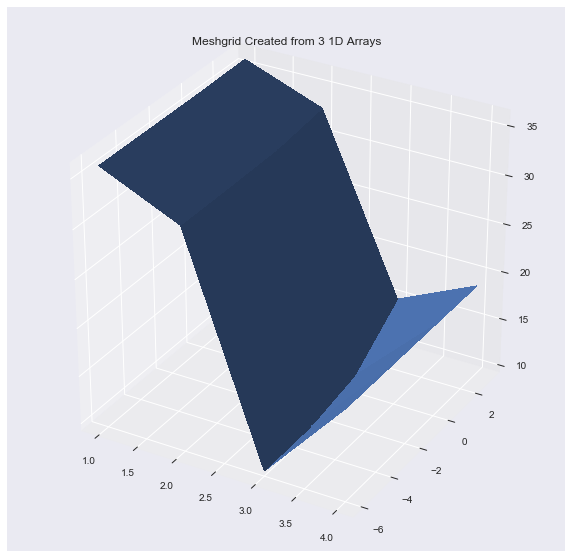

In [4]:
## 3-d plot for WR case
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10, 10))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1, projection='3d')


X = [_ for _ in range(1, 5)]
Y = [_ for _ in range(-6, 4, 3)]
X, Y = np.meshgrid(X, Y)




Z = [35.97186818210136,
   35.97186818274244,
   35.972407773448786,
   36.077109782287252,
   32.344548447480676,
   32.34456567853676,
   32.403437197102605,
   33.051546584021288,
   9.8078953156378592,
   9.9218941239852185,
   11.037224852109182,
   15.163250500514895,
   18.924687744320394,
   18.924687744320394,
   18.924687744320394,
   18.924687744320394]
Z_adj = [[Z[4*i + j] for i in range(4)] for j in range(4)]

surf = ax.plot_surface(X, Y, Z_adj, rstride=1, cstride=1,  linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.title('Meshgrid Created from 3 1D Arrays');
